##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: 조건부 GAN을 사용한 이미지 대 이미지 변환

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 튜토리얼은 Isola 등(2017)의 [조건부 적대 네트워크를 사용한 이미지 대 이미지 변환](https://arxiv.org/abs/1611.07004){:.external}에 설명된 대로 입력 이미지에서 출력 이미지에 매핑하는 작업을 학습하는 pix2pix라는 cGAN(조건부 생성 적대 네트워크)을 구축하고 훈련하는 방법을 보여줍니다. pix2pix는 애플리케이션에 특정하지 않습니다. 레이블 지도에서 사진 합성, 흑백 이미지에서 컬러 사진 생성, Google 지도 사진을 항공 이미지로 변환, 스케치를 사진으로 변환하는 등 다양한 작업에 적용할 수 있습니다..

이 예에서 네트워크는 [프라하에 있는 체코 공과 대학](https://www.cvut.cz/){:.external}의 [기계 인식 센터](http://cmp.felk.cvut.cz/){:.external}에서 제공하는 [CMP 외관 데이터베이스](http://cmp.felk.cvut.cz/~tylecr1/facade/)를 사용하여 건물 외관의 이미지를 생성합니다. 간단히 말해서 pix2pix 작성자가 만든 이 데이터세트의 [사전 처리된 복사본](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/){:.external}을 사용합니다.

pix2pix cGAN에서 입력 이미지에 대한 조건을 지정하고 해당 출력 이미지를 생성합니다. cGAN은 [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)(Mirza 및 Osindero, 2014)에서 처음 제안되었습니다.

네트워크 아키텍처에는 다음이 포함됩니다.

- [U-Net](https://arxiv.org/abs/1505.04597){:.external} 기반 아키텍처를 포함한 생성기
- 컨볼루셔널 PatchGAN 분류기로 표현되는 판별자([pix2pix 논문](https://arxiv.org/abs/1611.07004){:.external}에서 제안됨)

단일 V100 GPU에서 각 epoch는 약 15초가 소요될 수 있습니다.

다음은 외관 데이터세트에서 200 epoch를 훈련한 후 pix2pix cGAN에 의해 생성된 출력의 몇 가지 예입니다(80,000 스텝).

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png) ![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## TensorFlow 및 기타 라이브러리 가져오기

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## 데이터세트 로드하기

CMP 외관 데이터베이스 데이터(30MB)를 다운로드합니다. [여기](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)에서 추가 데이터세트를 동일한 형식으로 사용할 수 있습니다. Colab의 드롭다운 메뉴에서 다른 데이터세트를 선택할 수 있습니다. 다른 데이터세트 중 일부는 훨씬 더 큽니다(`edges2handbags`는 8GB).

In [ ]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [ ]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

In [ ]:
list(PATH.parent.iterdir())

각 원본 이미지는 `256 x 256` 이미지 2개가 포함된 `256 x 512` 크기입니다.

In [ ]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

In [ ]:
plt.figure()
plt.imshow(sample_image)

실제 건물 외관 이미지와 건축 레이블 이미지를 분리해야 합니다. 모든 이미지의 크기는 `256 x 256`입니다.

이미지 파일을 로드하고 두 개의 이미지 텐서를 출력하는 함수를 정의합니다.

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

입력(건축 레이블 이미지) 및 실제(건물 외관 사진) 이미지의 샘플을 플로팅합니다.

In [ ]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

[pix2pix 논문](https://arxiv.org/abs/1611.07004)에 설명된 대로 훈련 세트를 전처리하기 위해 랜덤 지터링과 미러링을 적용해야 합니다.

다음과 같은 여러 함수를 정의합니다.

1. 각 `256 x 256` 이미지의 크기를 더 큰 높이와 너비(`286 x 286`)로 조정합니다.
2. 무작위로 다시 `256 x 256`으로 자릅니다.
3. 이미지를 가로로 무작위로 뒤집습니다(예: 왼쪽에서 오른쪽으로 임의 미러링).
4. 이미지를 `[-1, 1]` 범위로 정규화합니다.

In [ ]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

사전 처리된 출력 중 일부를 검사할 수 있습니다.

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

로드 및 사전 처리가 작동하는지 확인했으므로 훈련 및 테스트세트를 로드하고 사전 처리하는 몇 가지 도우미 함수를 정의해 보겠습니다.

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## `tf.data`로 입력 파이프라인 구축하기

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 생성기 구축하기

pix2pix cGAN 생성기는 *수정된* [U-Net](https://arxiv.org/abs/1505.04597){:.external}입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)로 구성됩니다. [이미지 분할](../images/segmentation.ipynb) 튜토리얼과 [U-Net 프로젝트 웹사이트](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}에서 자세한 내용을 알아볼 수 있습니다.

- 인코더의 각 블록은 다음과 같습니다: 컨볼루션 -&gt; 배치 정규화 -&gt; 누출이 있는 ReLU
- 디코더의 각 블록은 다음과 같습니다: 전치된 컨볼루션 -&gt; 배치 정규화 -&gt; 드롭아웃(처음 3개 블록에 적용됨) -&gt; ReLU
- 인코더와 디코더 사이에는 건너뛰기 연결이 있습니다(U-Net에서와 같이).

다운샘플러(인코더) 정의:

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

업샘플러(디코더) 정의:

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

다운샘플러와 업샘플러로 생성기를 정의합니다.

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

생성기 모델 아키텍처 시각화:

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

생성기 테스트:

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 생성기 손실 정의하기

GAN은 데이터에 적응하는 손실을 학습하는 반면 cGAN은 [pix2pix 논문](https://arxiv.org/abs/1611.07004){:.external}에 설명된 대로 네트워크 출력 및 대상 이미지와 다른 가능한 구조에 불이익을 주는 구조화된 손실을 학습합니다.

- 생성기 손실은 생성된 이미지와 **1로 구성된 배열**의 시그모이드 교차 엔트로피 손실입니다.
- pix2pix 논문에는 생성된 이미지와 대상 이미지 간의 MAE(평균 절대 오차)인 L1 손실도 언급되어 있습니다.
- 이를 통해 생성된 이미지가 대상 이미지와 구조적으로 유사해질 수 있습니다.
- 총 생성기 손실을 계산하는 공식은 `gan_loss + LAMBDA * l1_loss`이고 여기서 `LAMBDA = 100`입니다. 이 값은 논문 저자가 결정했습니다.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

생성기의 훈련 절차는 다음과 같습니다.

![발전기 업데이트 이미지](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## 판별자 구축하기

pix2pix cGAN의 판별자는 컨볼루셔널 PatchGAN 분류기로, <a>pix2pix 논문</a>{:.external}에 설명된 대로 각 이미지 <em>패치</em>가 실제인지 아닌지를 분류하려고 합니다.

- 판별자의 각 블록은 다음과 같습니다: 컨볼루션 -&gt; 배치 정규화 -&gt; 누출이 있는 ReLU
- 마지막 레이어 이후의 출력 형상은 `(batch_size, 30, 30, 1)`입니다.
- 출력의 각 `30 x 30` 이미지 패치는 입력 이미지의 `70 x 70` 부분을 분류합니다.
- 판별자는 2개의 입력을 수신합니다.
    - 진짜로 분류해야 하는 입력 이미지 및 대상 이미지
    - 가짜로 분류해야 하는 입력 이미지와 생성된 이미지(생성기의 출력)
    - `tf.concat([inp, tar], axis=-1)`을 사용하여 이 2개의 입력을 함께 연결

판별자를 정의하겠습니다.

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

판별자 모델 아키텍처 시각화:

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

판별자 테스트:

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### 판별자 손실 정의하기

- `discriminator_loss` 함수는 **진짜 이미지**와 **생성된 이미지**의 두 입력을 받습니다.
- `real_loss`는 **진짜 이미지** 및 **1의 배열(실제 이미지이기 때문에)**의 시그모이드 교차 엔트로피 손실입니다.
- `generated_loss`는 **생성된 이미지** 및 **0의 배열(가짜 이미지이기 때문에)**의 시그모이드 교차 엔트로피 손실입니다.
- `total_loss`는 `real_loss`와 `generated_loss`의 합계입니다.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

판별자의 훈련 절차는 다음과 같습니다.

아키텍처와 하이퍼파라미터에 대한 자세한 내용은 [pix2pix 논문](https://arxiv.org/abs/1611.07004){:.external}을 참조하세요.

![판별 기 업데이트 이미지](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## 옵티마이저 및 체크포인트 세이버 정의하기


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 이미지 생성하기

훈련 중에 일부 이미지를 플롯하는 함수를 작성합니다.

- 테스트세트에서 생성기로 이미지를 전달합니다.
- 그러면 생성기가 입력 이미지를 출력으로 변환합니다.
- 마지막 단계는 예측을 플로팅하는 것입니다. *자 보세요*!

참고: 테스트 데이터세트에서 모델을 실행하는 동안 배치 통계를 원하기 때문에 여기서 `training=True`는 의도적입니다. `training=False`를 사용하면 훈련 데이터세트에서 학습된 누적 통계를 얻게 되는데, 이것은 원하는 것이 아닙니다.

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

함수 테스트:

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## 훈련하기

- 각 예제 입력에 대해 출력을 생성합니다.
- 판별자는 input_image 및 생성된 이미지를 첫 번째 입력으로 받습니다. 두 번째 입력은 input_image와 target_image입니다.
- 다음으로 생성기와 판별자 손실을 계산합니다.
- 그런 다음 생성기와 판별자 변수(입력) 모두에 대한 손실 기울기를 계산하고 이를 옵티마이저에 적용합니다.
- 마지막으로 TensorBoard에 손실을 기록합니다.

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

실제 훈련 루프. 이 튜토리얼은 둘 이상의 데이터세트를 실행할 수 있고 데이터세트의 크기가 크게 다르기 때문에 훈련 루프는 epoch 대신 단계적으로 작동하도록 설정됩니다.

- 스텝 수를 반복합니다.
- 10개 스텝마다 점(`.`)을 인쇄합니다.
- 1k 스텝마다: 디스플레이를 지우고 `generate_images`를 실행하여 진행 상황을 표시합니다.
- 5k 스텝마다: 체크포인트를 저장합니다.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

이 훈련 루프는 훈련 진행 상황을 모니터링하기 위해 TensorBoard에서 볼 수 있는 로그를 저장합니다.

로컬 머신에서 작업하는 경우 별도의 TensorBoard 프로세스를 시작합니다. 노트북에서 작업할 때는 TensorBoard로 모니터링하기 위한 교육을 시작하기 전에 뷰어를 실행하세요.

뷰어를 시작하려면 다음을 코드 셀에 붙여 넣습니다.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

마지막으로 훈련 루프를 실행합니다.

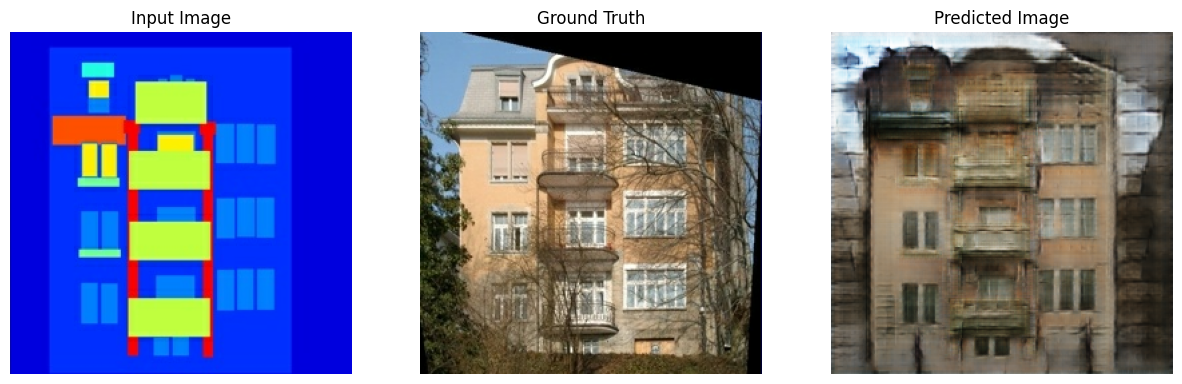

Step: 37k
.........................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

TensorBoard 결과를 *공개적으로* 공유하려면 다음을 코드 셀에 복사하여 [TensorBoard.dev](https://tensorboard.dev/)에 로그를 업로드할 수 있습니다.

참고: 이를 위해 구글 계정이 필요합니다.

```
!tensorboard dev upload --logdir {log_dir}
```

주의: 이 명령은 종료되지 않습니다. 장기 실행되는 실험 결과를 지속적으로 업로드하도록 설계되었습니다. 데이터가 업로드되면 노트북 도구에서 "실행 중단" 옵션을 사용하여 실행을 중단시켜야 합니다.

[TensorBoard.dev](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw)에서 이 노트북의 [이전 실행 결과](https://tensorboard.dev/)를 볼 수 있습니다.

[TensorBoard.dev](https://tensorboard.dev){:.external}는 ML 실험을 호스팅 및 추적하고 모든 사람과 공유하기 위한 관리형 환경입니다.

`<iframe>`을 사용하여 인라인으로 포함할 수도 있습니다.

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

로그 해석은 단순 분류 또는 회귀 모델에 비해 GAN(또는 pix2pix와 같은 cGAN)을 훈련할 때 처리하기가 더 어렵습니다. 주목해야 할 사항:

- 생성기 또는 판별자 모델 모두가 "이기"지 않는다는 것을 확인합니다. `gen_gan_loss` 또는 `disc_loss`가 매우 낮아지면 이 모델이 다른 모델을 지배하고 있어 결합된 모델을 성공적으로 훈련하지 못하고 있음을 나타내는 것입니다.
- 값 `log(2) = 0.69`는 이러한 손실에 대한 좋은 기준점입니다. 이는 2의 퍼플렉시티를 나타내기 때문입니다. 판별자는 평균적으로 두 옵션에 대해 똑같이 불확실합니다.
- `disc_loss`의 경우 `0.69` 미만의 값은 판별자가 실제 이미지와 생성된 이미지의 결합된 세트에서 무작위보다 더 효과적임을 의미합니다.
- `gen_gan_loss`의 경우 `0.69` 미만의 값은 생성기가 판별자를 속이는 데 있어 무작위보다 더 효과적임을 의미합니다.
- 훈련이 진행됨에 따라 `gen_l1_loss`가 내려갑니다.

## 최신 체크포인트 복원 및 네트워크 테스트

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 테스트세트를 사용하여 일부 이미지 생성하기

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)